In [ ]:
import matplotlib.pyplot as plt   
import numpy as np
import cv2 as cv2
import pyrealsense2 as rs

# àòlòl
# 

pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(r"C:\Users\Gianmy\Desktop\Coding\Test\bin22_d435_C_20210729_151839.bag") ##Works only with .bag files in C:/
profile = pipe.start(cfg)
playback = profile.get_device().as_playback()


ddd = profile.get_stream(rs.stream.depth)
intr = ddd.get_intrinsic()
print(intr)


playback.set_real_time(False)
# playback.pause()
# playback.resume()
#  TAKE MAX POROSITY FRAME FROM THE RECORDING         
# Skip the X frames to reach the max porosity frame number
for x in range(130):
    pipe.wait_for_frames()
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
color_frame_to_use = color_frame
depth_frame = frameset.get_depth_frame()
depth_frame_to_use = depth_frame
pipe.stop()

depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("depth_scale is : " ,depth_scale)

#Get color and depth frame aNAD CONVERT THEM TO AN ARRAY:
colorizer = rs.colorizer()

color_frame = np.asanyarray(color_frame.get_data()) 
colorized_d_frame = np.asanyarray(colorizer.colorize(depth_frame).get_data())
depth_frame =  np.asanyarray(depth_frame.get_data())

# Create alignment primitive function with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

#Create aligned frames:
aligned_color_frame = frameset.get_color_frame()
aligned_depth_frame = frameset.get_depth_frame()

#coloring depth image if needed
colorizer = rs.colorizer()
colorized_depth_image = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

#Rename Aligned frames as "image" to work with
color_image = np.asanyarray(aligned_color_frame.get_data())
color_image_RGB = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB);
depth_image = np.asanyarray(aligned_depth_frame.get_data())


# # TO WORK WITH POINTCLOUD, EXPORTING IT

# pc = rs.pointcloud();
# pc.map_to(color_frame_to_use);
# points = pc.calculate(depth_frame_to_use)
# v, t = points.get_vertices(), points.get_texture_coordinates()
# # verts = np.asanyarray(v).view(np.float32).reshape(-1, 3)  # xyz
# verts = np.asanyarray(v).view(np.float32).reshape(3, -1)  # xyz
# texcoords = np.asanyarray(t).view(np.float32).reshape(-1, 2)  # uv

# ply = rs.save_to_ply(r"C:\Users\Gianmy\Desktop\Coding\1ply.ply")
# # # Set options to the desired values
# # #in this example we'll generate a textual PLY with normals (mesh is already created by default)
# ply.set_option(rs.save_to_ply.option_ply_binary, False)
# ply.set_option(rs.save_to_ply.option_ply_mesh, False)
# ply.set_option(rs.save_to_ply.option_ply_normals, True)
# # ply.process(color_frame_to_use)

# points.export_to_ply("2.ply", color_frame_to_use);


# cloud = PyntCloud.from_file("2.ply");
# cloud.plot()


In [ ]:
from Grape_Click_Functions import *
name = "a"
image = color_image.copy()
colorized_img_depth = colorized_depth_image
img_depth = depth_image
Depth_Values_list,Depth_pix_Area_list = Show_Click(name,image, colorized_img_depth, img_depth)


# FUNCTIONS #

In [4]:
import matplotlib.pyplot as plt   
import math
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.cluster import KMeans
from collections import Counter

def show_img_compar(img_1, img_2 ):
        f, ax = plt.subplots(1, 2, figsize=(10,10))
        ax[0].imshow(img_1)
        ax[1].imshow(img_2)
        ax[0].axis('off') #hide the axis
        ax[1].axis('off')
        f.tight_layout()
        plt.show()


def get_BBOX_coords_from_YOLOv5_labes(color_image,pd_DF_txt_labels_file):
    #convert back to pixel coordinates YOLOv5 normalized coordinate(0-1)
    # Each row in txt file is class x_center, y_center, width, height, (conf thresh if present)
    # Box coordinates are in normalized xywh format (from 0 - 1).
    # If your boxes are in pixels, divide x_center and width by image width,
    # and y_center and height by image height.
    # ------------------ to open df correctly define it before runing the func-------------
    #     
    # pd_DF_txt_labels_file = pd.read_csv(r"C:\Users\Gianmy\Desktop\Coding\Test\1_.txt", delimiter = " ",
    #              names = ["class", "x_center", "y_center", "Box_width", "Box_height"])
    # ----------------------------------------------------
    df = pd_DF_txt_labels_file
    #convert to pixel coordinate (reverse the normalization)
    df["x_center"] = round(df["x_center"] *color_image.shape[1]) #x_center // .shape[1] = X = width
    df["y_center"] = round(df["y_center"] *color_image.shape[0]) #y_center //.shape[0] = Y = height
    df["Box_width"] =round(df["Box_width"]*color_image.shape[1]) # Box_width // .shape[1] = X = width
    df["Box_height"]= round(df["Box_height"]*color_image.shape[0]) # Box_height // .shape[1] = X = width
    df["Box_top_lef_X"]= round(df["x_center"]-(df["Box_width"]/2)) # pt1_X
    df["Box_top_lef_Y"]= round(df["y_center"]-(df["Box_height"]/2)) # pt1_Y
    df["Box_bot_rig_X"]= round(df["x_center"]+(df["Box_width"]/2)) # pt2_X
    df["Box_bot_rig_Y"]= round(df["y_center"]+(df["Box_height"]/2)) # pt2_Y
    
    #convert all df to integer 
    df_int = df.astype(int)
        
    BBOX_center_coords_list=[]
    for i in range(len(df_int["x_center"])):
        Xi= df_int["x_center"][i]
        Yi= df_int["y_center"][i]
        coords_i = (Xi,Yi)
        BBOX_center_coords_list.append(coords_i)
        
    BBOX_top_left_pt_list=[]
    for i in range(len(df_int["Box_top_lef_X"])):
        Xi= df_int["Box_top_lef_X"][i]
        Yi= df_int["Box_top_lef_Y"][i]
        coords_i = (Xi,Yi)
        BBOX_top_left_pt_list.append(coords_i)
        
    BBOX_bot_right_pt_list=[]
    for i in range(len(df_int["Box_top_lef_X"])):
        Xi= df_int["Box_bot_rig_X"][i]
        Yi= df_int["Box_bot_rig_Y"][i]
        coords_i = (Xi,Yi)
        BBOX_bot_right_pt_list.append(coords_i)
        
    BBOX_H_W_list=[]
    for i in range(len(df_int["Box_width"])):
        Xi= df_int["Box_width"][i]
        Yi= df_int["Box_height"][i]
        coords_i = (Xi,Yi)
        BBOX_H_W_list.append(coords_i)
    
    print(len(BBOX_center_coords_list), " fruit detected")
    
    return(BBOX_center_coords_list,BBOX_top_left_pt_list,BBOX_bot_right_pt_list,BBOX_H_W_list, df_int)

def order_YOLOv5_labels(labels_coords_list):
    x=0
    
    ######################
    ##  TO BE DONE
    #################
      
    
def extracting_Rectangle_ROI(depth_image,color_image,Rec_pt1,Rec_pt2):
    # ===============================
    # extrect BBOX ROI from the depth image using points defined in the labels
    # of neural net inferece (done on color image)
    
    # Rec_pt1 = Top Left ; Rec_pt1 = Bottom Right
    # ================================
    Rec_pt1= list(Rec_pt1) #need to be a list for getting rectangle coord
    Rec_pt2= list(Rec_pt2)
    ROI = depth_image.copy()   #we work on a clone to avoid having the roi rectangle in the image 
    ROI_depth = ROI[Rec_pt1[1]: Rec_pt2[1],Rec_pt1[0]:Rec_pt2[0]]
    ROI_coords_TUPLE = [Rec_pt1,[Rec_pt2[0],Rec_pt1[1]],[Rec_pt1[0],Rec_pt2[1]],Rec_pt2]
    ROI_color =color_image.copy()
    ROI_color =ROI_color[Rec_pt1[1]: Rec_pt2[1],Rec_pt1[0]:Rec_pt2[0]]
    
    
    return(ROI_depth,ROI_coords_TUPLE,ROI_color)


def get_circle_inside_the_BBOX():
    x=0 
    ######################
    ##  TO BE DONE
    ################# 


def mean_BBOX_color(roi):            
    img_temp = roi.copy()
    img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = np.average(roi, axis=(0,1))

    return(img_temp)

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_BBOX_color_perc(image, number_of_colors,fig_name, show_chart):
           
    modified_image =  image.copy()
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    

    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    value_perc_list = []
    for value in counts.values():
        value_perc = round(value/ sum(counts.values())*100 , 0)
        value_perc_list.append(value_perc)
    
    print("hex_ : ", hex_colors)
    print("RGB_ : ", rgb_colors )
    print("Color percentage: ", value_perc_list)
         
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors, autopct='%1.0f%%')
        plt.savefig(fig_name)
    
        
            
    return hex_colors, rgb_colors, value_perc_list

    
def mean_BBOX_dist(depth_roi, depth_scale):
    # ====================
    # give mean distance of the roi in millimeter exluding zero values in the depth picture
    # ====================
    ROI_np_array = np.asarray(depth_roi) #get only 1 channel and transfrom to array
    ROI_np_array_depth_scaled = ROI_np_array*depth_scale #to work in real world dimension
    
    zero_pix_perc = np.sum(depth_roi == 0) /depth_roi.size *100
    non_zero_pix_perc = np.sum(depth_roi > 0)/depth_roi.size *100
    tot_pix_perc = zero_pix_perc + non_zero_pix_perc
    
    ROI_nozero = ROI_np_array[np.nonzero(ROI_np_array)]
    ROI_nozero_mean = np.mean(ROI_nozero)
    ROI_nozero_sum = np.sum(ROI_nozero)
    
    mean_roi_dist = ROI_nozero_mean
    
    return(mean_roi_dist)

def pixel_real_dimension (roi_mean_distance, camera_type,RGB_original_image):
    #######################
    # need a function to get directly intrinsic or camera model
    ###########
    
    #!!!! CORRECT WITH MIRKOM SUGGESTION AND FORMULA
    
    if ( camera_type == "_d435" or camera_type == "D435"or
        camera_type == "_D435"or camera_type == "D435_" or
        camera_type == "_D435_"or camera_type == "_D43"or
        camera_type == "0_435"): #"D435i":
        Hfov = 69
        Vfov = 42
    elif ( camera_type == "_d455" or camera_type == "D455"
          or camera_type == "_D455" or camera_type == "D455_"
          or camera_type == "_D455_"or camera_type == "_D45"): #"D455":
        Hfov = 90
        Vfov = 65
    # else:
    #     print("camera type needed!")
    # defining radiant angle
    Hfov= math.radians(Hfov)
    Vfov= math.radians(Vfov)
    sq_angle = math.radians(90)
    plain_angle = math.radians(180)
    # scene dimension in meter
    H_scene_dim = 2* (roi_mean_distance*np.tan(Hfov/2))
    V_scene_dim = 2* (roi_mean_distance*np.tan((Vfov/2)))
    scene_area = H_scene_dim*V_scene_dim
    # pixel dimension in meter
    H_pix_dim = H_scene_dim/RGB_original_image.shape[0]
    V_pix_dim = V_scene_dim/RGB_original_image.shape[1]
    pix_area = scene_area/ (RGB_original_image.shape[1]*RGB_original_image.shape[0])
    mean_pix_dim = np.sqrt(pix_area)
    
    return (mean_pix_dim, pix_area)

# SCRIPT COMPLETO #
## Crea dataset finale con dimensione degli oggetti ##

In [11]:



# mypath = input("Enter Folder Path: ") 
mypath = input("INSERT folder path where color.jpeg, depth.npy and labels.txt files are stored: ")#r"C:\Users\Gianmy\Desktop\Coding\Nuova cartella\bins 1"

##########################
# checking in all dir and subdir for 
# files to be analyzed in base of the presence
# of .txt label file
#################################
count=0
bin_number_list=[]
camera_type_list=[]
coverture_list=[]
color_image_name_list =[]
depth_image_name_list = []
labels_file_name_list = []

labels_file_list= []
color_image_file_list =[]
depth_image_file_list = []
temp_image_with_no_labels_list = []

# get the list of all the available .txt files(labels)
# and create depth and color image name lists to be used later
# in checking which file to open
for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.startswith('color') and name.endswith('.txt'):
            # print(name)
            labels_file = os.path.join(path, name)  #complete path
            #get specific features in the name
            label_name =name[:-4]                   #file name without.txt
            bin_number = name[12:18]               
            camera_type =name[-18:-13]              
            coverture =name[-13:-10] 
            #get name of the different file type to be opened              
            col_label_file_name=label_name +".png"              #create 
            dep_label_file_name="depth"+label_name[5:]+".npy"
            #append everything you need
            bin_number_list.append(bin_number)
            camera_type_list.append(camera_type)
            coverture_list.append(coverture)
            labels_file_list.append(labels_file)
            labels_file_name_list.append(name)
            color_image_name_list.append(col_label_file_name)
            depth_image_name_list.append(dep_label_file_name) 
            
# create the lists with the complete path to be opened    
# only for file matching the label file name ,per each file type

for path, subdirs, files in os.walk(mypath):
    for name in files:
        #search through all files checking if ther name match with tha above lists
        # if so append the complete path to the dedicated file list to analyze
        # if name in labels_file_name_list:
            # print("ok")
        if name in color_image_name_list:
            # print(name ,"===",col_label_file_name )
            color_image_file_list.append(os.path.join(path, name))
        elif name.startswith('color') and name.endswith('.png'):
                temp_image_with_no_labels_list.append(name)    
        elif name in depth_image_name_list:
            depth_image_file_list.append(os.path.join(path, name))
        # else:
        #     print("image: ", name , "SKIPPED FOR MISSING LABELS")
 
image_with_no_labels_list = list(set(temp_image_with_no_labels_list) - set(color_image_name_list))

            
for i in image_with_no_labels_list:
    if i in color_image_name_list:
        image_with_no_labels_list.remove (i)
    
####################################################

print("folder to analyze: ", bin_number_list)

lst1 = ['bins/ image','camera','coverture', 'Fruit_Det.', 'scene.distance (mm)','fruitN', 'class', 'x_center', 'y_center',
       'Box_width','Box_height', 'confidence', 'Box_top_lef_X', 'Box_top_lef_Y','Box_bot_rig_X',
       'Box_bot_rig_Y', 'Obj.distance (mm)','pix.dimension (mm)', 'Obj.diam_max (mm)',
       'Obj.diam_min (mm)','MEAN diam_max (mm)', 'MEAN diam_min (mm)']
lst2 = ['bins/ image','camera','coverture', 'Fruit_Det.', 'scene.distance (mm)','MEAN pix.dimension (mm)',
        'MEAN diam_max (mm)', 'MEAN diam_min (mm)']

Final_DF_fruit_based = pd.DataFrame(columns = lst1)
Final_DF_bin_based = Final_DF_fruit_based.copy()


for bin_n in range(len(bin_number_list)):
    print("-------------------------------------")
    print("------------------- Analyzing bins: ",bin_number_list[bin_n])
    print("camera type : ",camera_type_list[bin_n])
    print("coverture : ",coverture_list[bin_n])
    
    
    color_image = plt.imread(color_image_file_list[bin_n])  
                                    
    pd_DF_txt_labels_file = pd.read_csv(labels_file_list[bin_n], delimiter = " ",
            names = ["class", "x_center", "y_center", "Box_width", "Box_height","confidence"])
    
    depth_image = np.load(depth_image_file_list[bin_n])
    
    ############################
    #  get the BBOX coordinates from labels  after detection
    # ##########################
   
    BBOX_center_coords_list,BBOX_top_left_pt_list,BBOX_bot_right_pt_list,BBOX_H_W_list, DF_data_e_labels= get_BBOX_coords_from_YOLOv5_labes(
    color_image,pd_DF_txt_labels_file)
    
    fruit_N_list=list(range(len(BBOX_center_coords_list)))

    ############################
    # get the ROI inside the depth picture based on 
    # label coordinates coming from Object detection
    # ##########################
    #test_image_to_show =color_image.copy()
   
    BBOX_depth_ROI_list = [] #store the ROI = images cuitted in the depth map
    BBOX_color_ROI_list = [] #store the ROI = images cuitted in the depth map
    for i in range(len(BBOX_center_coords_list)):
        Rec_pt1 = BBOX_top_left_pt_list[i]
        Rec_pt2 = BBOX_bot_right_pt_list[i]
        ROI_depth_i, ROI_coords_i, ROI_color_i = extracting_Rectangle_ROI(depth_image,color_image,Rec_pt1,Rec_pt2)
                   
        BBOX_depth_ROI_list.append(ROI_depth_i)
        BBOX_color_ROI_list.append(ROI_color_i)
                
    print("extracted ROI from labels.txt")
        
      
    ############################
    # get the single circle // contours insede the ROI detected
    # ##########################
        # def get_circle_inside_the_BBOX():
                
        
     
    ############################
    #  get mean ROI distance from the camera to use it after in estimating
    # real dimesion of each pixle
    # ##########################

    depth_scale = 0.001 ##FIND A WAY TO EXTRACT INFOS FROM BAG FILE 
    BBOX_depth_dist_list = [] #store the ROI = images cuitted in the depth map

    for i in range(len(BBOX_depth_ROI_list)):
    
        mean_roi_dist = mean_BBOX_dist (BBOX_depth_ROI_list[i], depth_scale)
        BBOX_depth_dist_list.append(mean_roi_dist)
   
    print("got distance from the camera per each object (ROI)")
 
     ############################
    # estimating  real dimesion of each pixle in mm (how many mm is 1 pixel)
    # ##########################
    BBOX_pix_dim_list = []
    BBOX_pix_area_list = []
    
    print("got distance from the camera per each object (ROI)")
    print("got distance from the camera per each object (ROI)")
    print("got distance from the camera per each object (ROI)")
    print(camera_type_list[bin_n])
    

    for i in range(len(BBOX_depth_dist_list)):
        mean_pix_dim, pix_area = pixel_real_dimension(BBOX_depth_dist_list[i], camera_type_list[bin_n] ,color_image)
        BBOX_pix_dim_list.append(mean_pix_dim)
        BBOX_pix_area_list.append(pix_area)
        
    
    print("real pixel dimensione estimated per each object, general mean = ", np.mean(BBOX_pix_dim_list))
 

    ############################
    # get pixel dimension of the BBOX you want to measure
    # ##########################

    BBOX_real_width_list = []
    BBOX_real_height_list =[]
    for i in range(len(BBOX_H_W_list)):
        Box_width_dim =BBOX_H_W_list[i][0] *BBOX_pix_dim_list[i]
        Box_height_dim=BBOX_H_W_list[i][1] *BBOX_pix_dim_list[i]
        BBOX_real_width_list.append(Box_width_dim)
        BBOX_real_height_list.append(Box_height_dim)
        
    # reorder box dimension in min and max diam list
    diam_max_list =[]
    diam_min_list=[]
    diam_mean_list=[]

    for i in range(len(BBOX_real_width_list)):
        both_dimesion = [BBOX_real_width_list[i],BBOX_real_height_list[i]]
        diam_max = np.max(both_dimesion)
        diam_min = np.min(both_dimesion)
        diam_mean = np.mean(both_dimesion)
        diam_max_list.append(diam_max)
        diam_min_list.append(diam_min)
        diam_mean_list.append(diam_mean)
        
    print("got 2 diameter per each object... mean value = ", np.mean(diam_mean_list))

     ############################
    # get Color percentage of the object
    # ##########################
    number_of_colors = 5
    
    hex_colors_list = []
    hex_colors = []
    value_perc_list = []
    
    for i in BBOX_color_ROI_list:
        print(type(i))
        fig_name = color_image_name_list[bin_n]
        hex_colors, rgb_colors, value_perc_list = get_BBOX_color_perc(i, number_of_colors, fig_name, show_chart=True)
    ##### define color threshold and how to svae results 
    

                
    # create the PER BINS (IMAGE) ENDING DATAFRAME:
    DF_data_e_labels
    df_fruit_based = DF_data_e_labels.copy()
    
    df_fruit_based.insert(0,"bins/ image", bin_number_list[bin_n])  #add name of the bins/image analyzed
    df_fruit_based.insert(1,"camera", camera_type_list[bin_n])  #add name of the bins/image analyzed
    df_fruit_based.insert(2,"coverture", coverture_list[bin_n])  #add name of the bins/image analyzed
    df_fruit_based.insert(3,"Fruit_Det.", len(fruit_N_list))  #add total fruit detected per bins
    df_fruit_based.insert(4,"scene.distance (mm)", np.mean(BBOX_depth_dist_list))  #add name of the fruit considered
    df_fruit_based.insert(5,"fruitN", fruit_N_list)  #add name of the fruit considered
    df_fruit_based["Obj.distance (mm)"] =BBOX_depth_dist_list  #add column for obj distance
    df_fruit_based["pix.dimension (mm)"] =BBOX_pix_dim_list  #add column for pxi. dimension in mm
    df_fruit_based["Obj.diam_max (mm)"] =diam_max_list  #add column for obj distance
    df_fruit_based["Obj.diam_min (mm)"] =diam_min_list  #add column for obj distance
    df_fruit_based["MEAN diam_max (mm)"] =np.mean(diam_max_list)  #add column for scene distance(mean of all obj. distance detecte)
    df_fruit_based["MEAN diam_min (mm)"] =np.mean(diam_min_list)  #add column for scene distance(mean of all obj. distance detecte)

    Final_DF_fruit_based = Final_DF_fruit_based.append(df_fruit_based)
    Final_DF_bin_based = Final_DF_bin_based.append(df_fruit_based.iloc[[0]])
        
    print("")
    print("------------- bins n. ", bin_number_list[bin_n], "analyzed and saved")
    print("-------------------------------------------------")

# adding undetected image at the end of the DF to keep track
lst3 =["NaN"]*len(list(Final_DF_bin_based.columns))
lst4 =["NaN"]*len(list(Final_DF_fruit_based.columns))
for i in image_with_no_labels_list:  
    lst3[0] = str(i)
    lst4[0] = str(i)
    #adding undetected pictures at the end of the DFF
    Final_DF_bin_based.loc[len(Final_DF_bin_based.index)] = lst3 
    Final_DF_fruit_based.loc[len(Final_DF_fruit_based.index)] = lst4 


print("saving the final dataset...")
with pd.ExcelWriter('Final_DF_ridolfi.xlsx') as writer:  
    Final_DF_fruit_based.to_excel(writer, sheet_name='Fruit_based')
    Final_DF_bin_based.to_excel(writer, sheet_name='Bins_Based')


print("SAVED TO... /Final_DF_ridolfi.xlsx ")
print("")
'''
print("---  ### END OF THE CODE ## ---")

# print(Final_DF_fruit_based.head())
# print(Final_DF_bin_based.head())


folder to analyze:  ['bins1_']
-------------------------------------
------------------- Analyzing bins:  bins1_
camera type :  _D435
coverture :  _C_


IndexError: list index out of range

# foto porfondita' con detection #

In [2]:
import cv2
import pandas as pd

# color_image = cv2.imread(r"C:\Users\Gianmy\Desktop\Coding\RIDOLFI\Test\Foto_ridolfi\bin1\color_image_bins1_D435_C_092640.png")
# #PATH TO TXT FILE WITH LABELS COMING FROM YOLOV5 DETECIOTN
# pd_DF_txt_labels_file =pd.read_csv(r"C:\Users\Gianmy\Desktop\Coding\RIDOLFI\Test\Foto_ridolfi\bin1\color_image_bins1_D435_C_092640.txt", delimiter = " ",
#         names = ["class", "x_center", "y_center", "Box_width", "Box_height","confidence"])

# # BBOX_center_coords_list,BBOX_top_left_pt_list,BBOX_bot_right_pt_list,BBOX_H_W_list, DF_data_e_labels= get_BBOX_coords_from_YOLOv5_labes(
# # color_image,pd_DF_txt_labels_file)
# BBOX_center_coords_list,BBOX_top_left_pt_list,BBOX_bot_right_pt_list,BBOX_H_W_list, DF_data_e_labels= get_BBOX_coords_from_YOLOv5_labes(
# color_image,pd_DF_txt_labels_file)

# fruit_N_list=list(range(len(BBOX_center_coords_list)))

# ############################
# # get the ROI inside the depth picture based on 
# # label coordinates coming from Object detection
# # ##########################
# #test_image_to_show =color_image.copy()
# Depth_Colorized_Image = cv2.imread(r"C:\Users\Gianmy\Desktop\Coding\RIDOLFI\Test\Foto_ridolfi\bin1\colorized_depth_image_bins1_D435_C_092640.png")
# # Depth_Colorized_Image= cv2.cvtColor(Depth_Colorized_Image,cv2.COLOR_BGR2RGB)
# # plt.imshow(Depth_Colorized_Image)

# BBOX_depth_ROI_list = [] #store the ROI = images cuitted in the depth map
# BBOX_color_ROI_list = [] #store the ROI = images cuitted in the depth map
# for i in range(len(BBOX_center_coords_list)):
#     Rec_pt1 = BBOX_top_left_pt_list[i]
#     Rec_pt2 = BBOX_bot_right_pt_list[i]
#     # ROI_depth_i, ROI_coords_i, ROI_color_i = extracting_Rectangle_ROI(depth_image,color_image,Rec_pt1,Rec_pt2)
        
#     Depth_with_box = cv2.rectangle(Depth_Colorized_Image, Rec_pt1, Rec_pt2,(255,255,255),3)
#     plt.imshow(Depth_Colorized_Image)
#     cv2.imwrite("Depth_with_box.jpeg",Depth_Colorized_Image)
                
# print("Image saved")


Depth_Colorized_Image = cv2.imread(r"C:\Users\Gianmy\Desktop\MicrosoftTeams-image.png")
Depth_Colorized_Image= cv2.cvtColor(Depth_Colorized_Image,cv2.COLOR_BGR2RGB)
cv2.imwrite("Depth_with_box.jpeg",Depth_Colorized_Image)

True

# TEST COILOR #

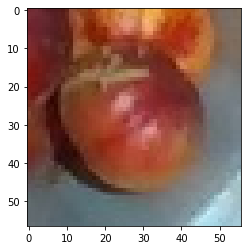

In [9]:
def RGB2HEX(color):
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_BBOX_color_perc(image, number_of_colors, show_chart):
    
    def RGB2HEX(color):
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
       
    modified_image =  image.copy()
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    value_perc_list = []
    for value in counts.values():
        value_perc = round(value/ sum(counts.values())*100 , 0)
        value_perc_list.append(value_perc)
    
    print("hex_ : ", hex_colors)
    print("RGB_ : ", rgb_colors )
    print("Color percentage: ", value_perc_list)
    print("ordered_colors: ", ordered_colors)
 
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = rgb_colors, colors = rgb_colors, autopct='%1.0f%%')
        plt.savefig(fig_name)
    
        
            
    return hex_colors, rgb_colors, value_perc_list



img = plt.imread(r"C:\Users\Gianmy\Desktop\Coding\RIDOLFI\Test\color_image_bin22_d435_C_1518399.jpg")
plt.imshow(img) #plt.imshow(BBOX_color_ROI_list[1])

B,G,R = cv.split(img)

# plt.imshow(BBOX_color_ROI_list[1])



########  LASCIA TUTTO ############
# number_of_colors = 5
  
# hex_colors_list = []
# hex_colors = []
# value_perc_list = []

# img = cv.imread(r"C:\Users\Gianmy\Desktop\Coding\Test\color_image_bin22_d435_C_1518399.jpg")
# plt.imshow(img) #plt.imshow(BBOX_color_ROI_list[1])


# fig_name = "prova" #color_image_name_list[bin_n]
# hex_colors, rgb_colors, value_perc_list = get_BBOX_color_perc(img, number_of_colors,  show_chart=False)
    
# for i in BBOX_color_ROI_list[1]:
#     print(type(i))
#     plt.imshow(i)
#     # fig_name = color_image_name_list[bin_n]
    # hex_colors, rgb_colors, value_perc_list = get_BBOX_color_perc(i, number_of_colors, fig_name, show_chart=True)
##### define color threshold and how to svae results 


## COLOR DISTANCE FORMULA ##

---------
red:  0  NON red:  10000
red:  0.0 NON red:  1.0


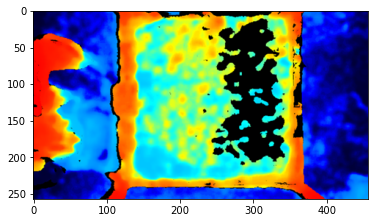

In [12]:
from skimage import color as col
img = cv.imread(r"C:\Users\Gianmy\Desktop\MicrosoftTeams-image.png")

image = img[0:100,0:100]
selected_color = [127,127,127]

im_test =np.ones(image.shape)
im_test =im_test*selected_color


plt.imshow(img)

threshold = 0
red_pix_count=0
non_red_pix_count =0

for y in range(image.shape[0]):
       for x in range(image.shape[1]):
           pixel_color = image[y][x]
           lab_pixel_color=col.rgb2lab(np.uint8(np.asarray([pixel_color])))
           diff = col.deltaE_cie76(selected_color, lab_pixel_color)
           if (diff < threshold):
               red_pix_count = red_pix_count+1
           if (diff >= threshold):
               non_red_pix_count = non_red_pix_count+1
print("---------")
print("red: ",red_pix_count, " NON red: ",non_red_pix_count)      
print("red%: ", red_pix_count/(image.shape[0]*image.shape[1]),
      "NON red %: ", non_red_pix_count/(image.shape[0]*image.shape[1]))         
         
           
           
           

In [12]:
from skimage import color as col

colors = {'RED':[128,0,0]}

def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    hex_colors, rgb_colors, value_perc_list = get_colors(image, number_of_colors, False)
    selected_color = color.rgb2lab(np.uint8(np.asarray([[color]])))
    
    for y in range(image.shape[0]):
       for x in range(image.shape[1]):
           pixel_color = image[y][x]
           lab_pixel_color=color.rgb2lab(np.uint8(np.asarray([pixel_color])))
           
           
           
           print(image[y][x])


    for i in range(number_of_colors):
        curr_color = color.rgb2lab(np.uint8(np.asarray([[rgb_colors[i]]])))
        diff = color.deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

 # codice per copiare file # 

In [ ]:
import shutil

src_dir= r"C:\Users\Gianmy\Desktop\RGBd Ridolfi\renamed"
dst_dir= r"C:\Users\Gianmy\Documents\Università\AGRARIA\2021\Tesi\Luca Zappi - Ridolfi Pesche\FOTO"
# os.makedirs(dst_dir)

for path, subdirs, files in os.walk(src_dir):
    for name in files:
        # if name.startswith('colorized') and name.endswith('.png'):
        #     shutil.copy(os.path.join(path, name),dst_dir)
        if name.startswith('depth') and name.endswith('.npy'):
            shutil.copy(os.path.join(path, name),dst_dir)

# Test hough circle #

In [ ]:


import numpy as np
import cv2 as cv
# img = cv.imread(r,0)
# img = BBOX_color_ROI_list[1]
img = cv.imread(r"C:\Users\Gianmy\Desktop\Coding\Test\color_image_bin22_d435_C_1518399.jpg")
min_BBOX_dimension = list(img.shape)
min_BBOX_dimension = np.min(min_BBOX_dimension[0:1])
max_circle_radius = int( min_BBOX_dimension)
min_circle_radius = int(max_circle_radius/2)

print(max_circle_radius)
print(min_circle_radius)



G_img = cv.cvtColor(img,cv.COLOR_RGB2GRAY)

print(type(img))

img = cv.medianBlur(G_img,5)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

# Parameters 1 and 2 don't affect accuracy as such, more reliability.
# Param 1 will set the sensitivity; how strong the edges of the circles need to be.
# Too high and it won't detect anything, too low and it will find too much clutter.
# Param 2 will set how many edge points it needs to find to declare that it's found a circle.
# Again, too high will detect nothing, too low will declare anything to be a circle.
# The ideal value of param 2 will be related to the circumference of the circles.

ret, thresh = cv.threshold(G_img, 100, 255, 0)

plt.imshow(thresh)

# im2, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)




circles = cv.HoughCircles(G_img,cv.HOUGH_GRADIENT,1.5,20,
                            param1=50,param2=100,minRadius=30,maxRadius=100)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img,(i[0],i[1]),2,(0,0,255),3)



# cv.imshow('detected circles',img)
# cv.waitKey(0)
# cv.destroyAllWindows()

